In [1]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt

[yfinance documentation](https://pypi.org/project/yfinance/)

[Geeks for Geeks Tutorial](https://www.geeksforgeeks.org/get-financial-data-from-yahoo-finance-with-python/)

### Canada Oil and Gas

In [2]:
suncor_t = yf.Ticker('SU')
enbridge_t = yf.Ticker('ENB')
cenovus_t = yf.Ticker('CVE')


### Canada Tech


In [3]:
shopify_t = yf.Ticker('SHOP')
constsoft_t = yf.Ticker('CSU')
nuvei_t = yf.Ticker('NVEI')


In [4]:
### Get the ticker stock history in a dataframe ###
### Input the start and end dates and stock symbol ###
def get_tick_hist_df(start, end, symbol):
    
    ticker = yf.Ticker(symbol)
    df = ticker.history(start=start, end=end)
    df.title = symbol
    return df

In [5]:
suncor_df = get_tick_hist_df("2020-04-01", "2022-04-01", 'SU')
enbridge_df = get_tick_hist_df("2020-04-01", "2022-04-01", 'ENB')
cenovus_df = get_tick_hist_df("2020-04-01", "2022-04-01", 'CVE')


In [6]:
shopify_df = get_tick_hist_df("2020-04-01", "2022-04-01", 'SHOP')
nvidia_df = get_tick_hist_df("2020-04-01", "2022-04-01", 'NVDA')
c3_df = get_tick_hist_df("2020-04-01", "2022-04-01", 'AI')

In [7]:
def plot_col(df,column):
    df[column].to_frame().plot()


<AxesSubplot:xlabel='Date'>

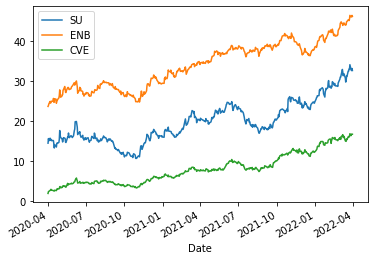

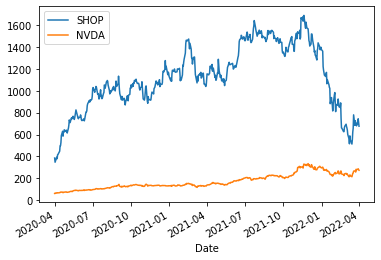

In [8]:
# Plot multiple stocks together in same plot
# Inputs are a list of stock history dataframes and the column to plot #

def plot_mult_dfs(dfs, column):
    data = {}
    for df in dfs:
        data[df.title] = df[column].values
    while True:
        try: 
            index = dfs[0].index
            new_df = pd.DataFrame(data, index=index)
            return new_df.plot()
        except ValueError:
            print("Length of data doesn't match")
            return

    
plot_mult_dfs([suncor_df, enbridge_df, cenovus_df], 'Close')
plot_mult_dfs([shopify_df, nvidia_df], 'Close')


In [9]:
# Create list of stocks to then plot against eachother 
# Input start and end date for stock history
# List of stock symbols
# Column to ploth - usually 'Close' which is the closing price

def plot_shares(start, end, stocks, column):
    dfs = []
    for stock in stocks:
        df = get_tick_hist_df(start, end, stock)
        dfs.append(df)
    plot_mult_dfs(dfs, column)

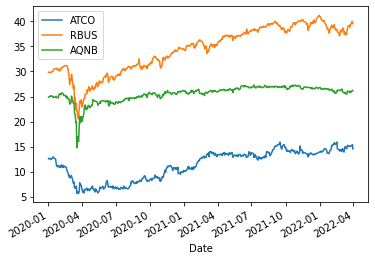

In [10]:
rand_stocks = ['ATCO', 'RBUS', 'AQNB']
plot_shares("2020-01-01", "2022-04-01", rand_stocks, 'Close')


In [11]:
# plot_col(suncor_df,'Close')
# plot_col(enbridge_df, 'Close')
# plot_col(cenovus_df, 'Close')

### Check stocks trend using differencing method from lecture 2.3

In [12]:
def plot_difference(start, end, stocks, column):
    for stock in stocks:
        df = get_tick_hist_df(start, end, stock)
        df_prices = df[column].to_frame()
        df_prices['Differences'] = df_prices[column] - df_prices[column].shift()
        df_prices.plot()

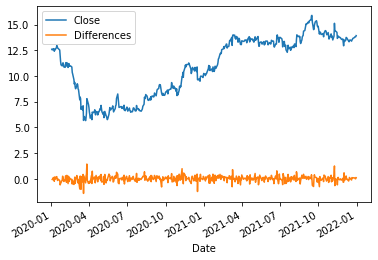

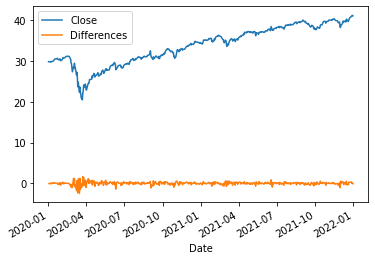

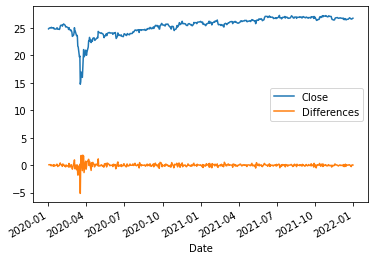

In [13]:
plot_difference('2020-01-01', '2022-01-01', rand_stocks, 'Close')

## Seasonality

Check atco for seasonality

In [14]:
df_atco = get_tick_hist_df('2010-01-01', '2022-01-01', 'ATCO')
df_atco_price = df_atco['Close'].to_frame()
df_atco_price.head()

,Close
Date,
2010-01-04,4.557512
2010-01-05,4.609787
2010-01-06,4.676321
2010-01-07,4.657312
2010-01-08,4.885423


<AxesSubplot:xlabel='Date'>

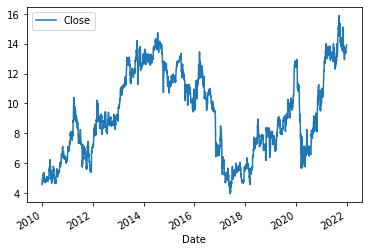

In [15]:
df_atco_price.plot()

In [16]:
def get_season_means(df, column, num_seasons):
    season_sum = [0]*num_seasons
    season_count = [0]*num_seasons
    season_mean = [0]*num_seasons
    # use running totals to get monthly sum and monthly count
    for i, value in enumerate(df[column]):
        season_sum[i % num_seasons] += df[column][i]
        season_count[i % num_seasons] += 1
    # calculate monthly avg
    for i in range(num_seasons):
        season_mean[i] = season_sum[i] / season_count[i]
    return season_mean

atco_month_mean = get_season_means(df_atco_price, 'Close', 4)
print(atco_month_mean)

[9.29902619722659, 9.304013446782598, 9.29441995747042, 9.29724702171932]


In [17]:
import numpy as np

def get_overall_mean(df, column):
    mean = np.mean(df[column].values)
    return mean

atco_overall_mean = get_overall_mean(df_atco_price, 'Close')
print(atco_overall_mean)

9.298676771503613


In [18]:
def get_season_offsets(mean, season_means, num_seasons):
    season_offsets = [0]*num_seasons
    for i in range(num_seasons):
        season_offsets[i] = season_means[i] - mean
    return season_offsets


In [19]:
atco_seasonal_offsets = get_season_offsets(atco_overall_mean, atco_month_mean, 4)
print(atco_seasonal_offsets)

[0.00034942572297680385, 0.005336675278984515, -0.0042568140331926685, -0.0014297497842932216]


#### Calculate new adjusted values and create column in dataframe

In [20]:
def get_seasonally_adj_df(df, column, offsets):
    seasonally_adj = []
    num_seasons = len(offsets)
    for i, val in enumerate(df[column]):
        seasonally_adj.append( val - offsets[i % num_seasons])
    df.insert(1, 'Seasonally Adjusted', seasonally_adj)
    return df


In [21]:
atco_adjusted_df = get_seasonally_adj_df(df_atco_price, 'Close', atco_seasonal_offsets)
atco_adjusted_df.head()

,Close,Seasonally Adjusted
Date,,
2010-01-04,4.557512,4.557163
2010-01-05,4.609787,4.604451
2010-01-06,4.676321,4.680578
2010-01-07,4.657312,4.658742
2010-01-08,4.885423,4.885073


<AxesSubplot:xlabel='Date'>

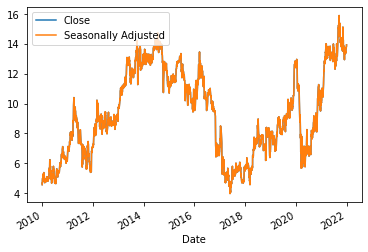

In [22]:
atco_adjusted_df.plot()

In [23]:
def get_seasonally_adjuted_stock_data(start, end, symbol, num_seasons):
    df = get_tick_hist_df(start, end, symbol)
    df_price = df['Close'].to_frame()
    seasonal_means = get_season_means(df_price, 'Close', num_seasons)
    overall_mean = get_overall_mean(df_price, 'Close')
    seasonal_offsets = get_season_offsets(overall_mean, seasonal_means, num_seasons)
    print(seasonal_offsets)
    adjusted_df = get_seasonally_adj_df(df_price, 'Close', seasonal_offsets)
    return adjusted_df

    

[0.023299735180820846, -0.002642681237347233, -4.2774315957672115e-05, -0.04568456568533463, -0.06550290579566109, -0.09491116039631464, -0.022669600309313864, 0.033010849911640605, 0.032135183423022795, -0.015312348921234786, 0.05051804794493364, 0.10775302144271137]


<AxesSubplot:xlabel='Date'>

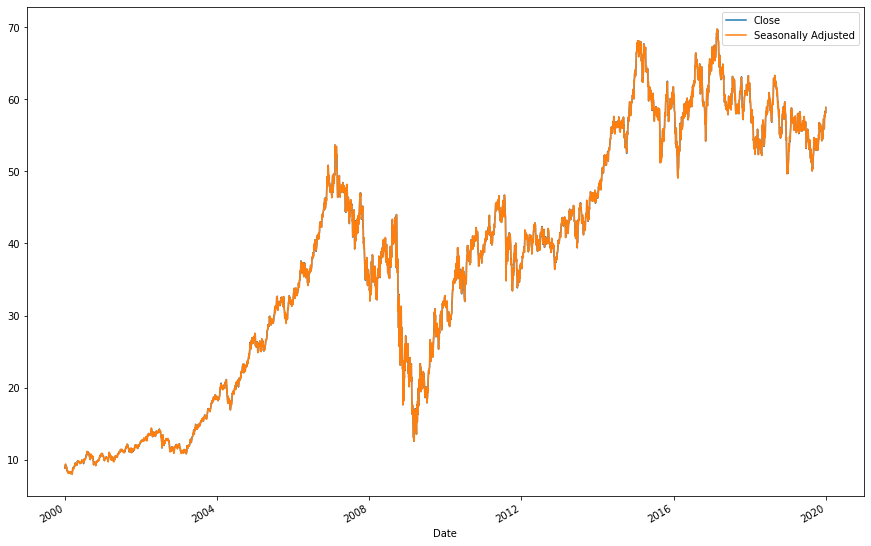

In [24]:
df_adj = get_seasonally_adjuted_stock_data('2000-01-01','2020-01-01','VNO', 12)
# atco_adj['Seasonally Adjusted'].plot()
df_adj.plot(figsize=(15,10))

# Multiplicativity

In [25]:
# check for mulitplicativity
df_atco['diff'] = np.abs(df_atco['Close'] - df_atco['Close'].shift())
df_atco.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,diff
Date,,,,,,,,
2010-01-04,4.424446,4.562265,4.405437,4.557512,286000,0.0,0,NaN
2010-01-05,4.548007,4.643054,4.548007,4.609787,341800,0.0,0,0.052275
2010-01-06,4.638302,4.704835,4.609788,4.676321,335500,0.0,0,0.066534
2010-01-07,4.671569,4.700084,4.609789,4.657312,221300,0.0,0,0.019009
2010-01-08,4.609786,4.909185,4.609786,4.885423,476700,0.0,0,0.228110


<AxesSubplot:xlabel='Close', ylabel='diff'>

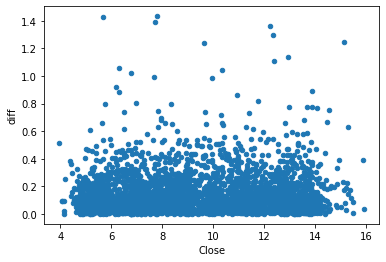

In [26]:
df_atco.plot.scatter(x='Close', y='diff')

Looks pretty flat, don't see the y=x type pattern so no multiplicativity

Try a co2 emissions dataset

In [38]:
c02_df = pd.read_csv('./data/c02emissions.csv')


In [39]:
c02_df.describe()

,Year,Month,Decimal Date,Carbon Dioxide (ppm),Seasonally Adjusted CO2 (ppm),Carbon Dioxide Fit (ppm),Seasonally Adjusted CO2 Fit (ppm)
count,720.000000,720.000000,720.000000,703.000000,703.000000,707.000000,707.000000
mean,1987.500000,6.500000,1987.997492,352.375633,352.375206,352.054074,352.049830
std,17.330141,3.454452,17.332539,26.241884,26.171620,26.241431,26.178904
min,1958.000000,1.000000,1958.041100,313.210000,314.420000,312.450000,314.890000
25%,1972.750000,3.750000,1973.019900,328.555000,329.010000,328.340000,328.400000
50%,1987.500000,6.500000,1987.998600,349.800000,349.820000,349.370000,349.270000
75%,2002.250000,9.250000,2002.977425,373.195000,372.935000,372.840000,372.605000
max,2017.000000,12.000000,2017.956200,407.650000,406.040000,407.280000,405.830000


<AxesSubplot:>

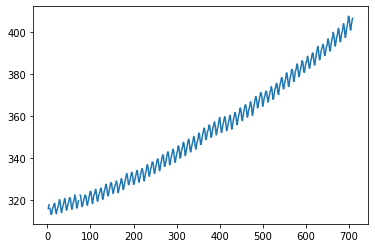

In [40]:
c02_df['Carbon Dioxide (ppm)'].plot()

In [41]:
c02_df['diff'] = np.abs(c02_df['Carbon Dioxide (ppm)'] - c02_df['Carbon Dioxide (ppm)'].shift())

<AxesSubplot:xlabel='Carbon Dioxide (ppm)', ylabel='diff'>

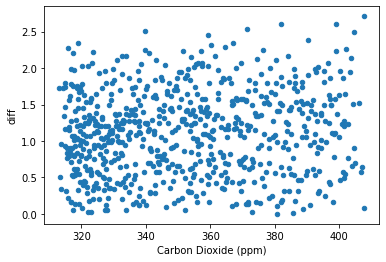

In [42]:
c02_df.plot.scatter(x='Carbon Dioxide (ppm)', y='diff')

In [46]:
c02_df['log co2'] = np.log(c02_df['Carbon Dioxide (ppm)'])
c02_df.head()

,Year,Month,Decimal Date,Carbon Dioxide (ppm),Seasonally Adjusted CO2 (ppm),Carbon Dioxide Fit (ppm),Seasonally Adjusted CO2 Fit (ppm),diff,log co2,log diff
0,1958,1,1958.0411,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1958,2,1958.1260,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1958,3,1958.2027,315.69,314.42,316.18,314.89,NaN,5.754761,NaN
3,1958,4,1958.2877,317.45,315.15,317.30,314.98,1.76,5.760320,0.005560
4,1958,5,1958.3699,317.50,314.73,317.83,315.06,0.05,5.760478,0.000157


<AxesSubplot:xlabel='log co2', ylabel='log diff'>

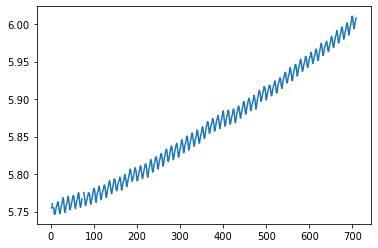

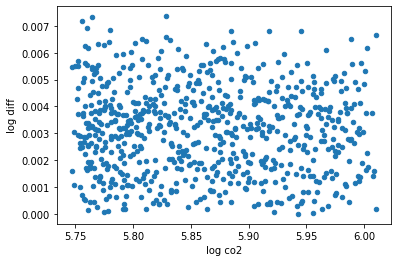

In [45]:
c02_df['log diff'] = np.abs(c02_df['log co2'] - c02_df['log co2'].shift())
c02_df['log co2'].plot()
c02_df.plot.scatter(x='log co2', y='log diff')